In [12]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to save the model
import joblib

In [13]:
# load the unseen / new dataset
data = pd.read_csv('data/house_prices/test.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
# drop the id variable
X_test = data.drop('Id', axis=1)

X_test.shape

(1459, 79)

## Missing values

We follow step-by-step from the feature engineering step (02).

### Missing categorical variables

In [15]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ['MSSubClass']

X_test[cat_vars] = X_test[cat_vars].astype('O')

In [16]:
with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']

with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

# hard-coded => hidden bug if distribution changes.

In [17]:
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

for var in with_frequent_category.keys():
    X_test[var].fillna(with_frequent_category[var], inplace=True)

### Missing numerical variables 

In [18]:
vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356,
}

# replace missing values as we described above
for var in vars_with_na.keys():

    # add binary missing indicator (in train and test)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_test[var].fillna(vars_with_na[var], inplace=True)

X_test[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [19]:
# check the binary missing indicator variables
X_test[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## Temporal variables

In [20]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [21]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_test = elapsed_years(X_test, var)

# drop year sold
X_test.drop(['YrSold'], axis=1, inplace=True)

In [22]:
X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,20,RH,80.0,11622,Pave,Missing,Reg,Lvl,AllPub,Inside,...,Missing,MnPrv,Missing,0,6,WD,Normal,0,0,0
1,20,RL,81.0,14267,Pave,Missing,IR1,Lvl,AllPub,Corner,...,Missing,Missing,Gar2,12500,6,WD,Normal,0,0,0
2,60,RL,74.0,13830,Pave,Missing,IR1,Lvl,AllPub,Inside,...,Missing,MnPrv,Missing,0,3,WD,Normal,0,0,0
3,60,RL,78.0,9978,Pave,Missing,IR1,Lvl,AllPub,Inside,...,Missing,Missing,Missing,0,6,WD,Normal,0,0,0
4,120,RL,43.0,5005,Pave,Missing,IR1,HLS,AllPub,Inside,...,Missing,Missing,Missing,0,1,WD,Normal,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,Missing,Reg,Lvl,AllPub,Inside,...,Missing,Missing,Missing,0,6,WD,Normal,0,0,1
1455,160,RM,21.0,1894,Pave,Missing,Reg,Lvl,AllPub,Inside,...,Missing,Missing,Missing,0,4,WD,Abnorml,0,0,0
1456,20,RL,160.0,20000,Pave,Missing,Reg,Lvl,AllPub,Inside,...,Missing,Missing,Missing,0,9,WD,Abnorml,0,0,0
1457,85,RL,62.0,10441,Pave,Missing,Reg,Lvl,AllPub,Inside,...,Missing,MnPrv,Shed,700,7,WD,Normal,0,0,1


## Numerical transformation

### Log transform

In [23]:
log_transform_vars = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']
for var in log_transform_vars:
    X_test[var] = np.log(X_test[var])

### Yeo-Johnson transform

In [24]:
lmbda=1.3691476824548794
X_test['LotArea'] = stats.yeojohnson(X_test['LotArea'], lmbda=lmbda)

## Binarize zero skewed

In [25]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed: 
    # recall these variables are almost always zero
    X_test[var] = np.where(X_test[var]==0, 0, 1)

## Encode categorical

In [26]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    X_test[var] = X_test[var].map(qual_mappings)

In [27]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

X_test[var] = X_test[var].map(exposure_mappings)

In [28]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    X_test[var] = X_test[var].map(finish_mappings)

In [29]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

X_test[var] = X_test[var].map(garage_mappings)

In [30]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_test[var] = X_test[var].map(fence_mappings)

In [31]:
with_null_test = [var for var in X_test.columns if X_test[var].isnull().sum() > 0]

with_null_test

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [32]:
features = pd.read_csv('models/selected_features.csv')['0'].tolist()
X_test[features].isnull().sum().sum() # 219 missing values after imputation!

11

**IMPORTANT:** In the new data, we have a bunch of variables that contain missing information, that we did not anticipate.

## Removing rare labels

In [33]:
# capture the remaining categorical variables (those that we did not re-map)
processed_vars  = qual_vars + finish_vars + ['BsmtExposure', 'GarageFinish', 'Fence']

cat_others = [var for var in cat_vars if var not in processed_vars]

len(cat_others)

30

In [34]:
frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}


In [35]:
for var in frequent_ls.keys():
    
    # replace rare categories by the string "Rare"
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

## Target encoding categorical

In [36]:
ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}


In [37]:
for var in ordinal_mappings.keys():

    ordinal_label = ordinal_mappings[var]

    # use the dictionary to replace the categorical strings by integers
    X_test[var] = X_test[var].map(ordinal_label)

## Null values in new data

In [38]:
# check absence of na in the data set

with_null = [var for var in X_test.columns if X_test[var].isnull().sum() > 0]

len(with_null)


13

In [39]:
# there is missing data in a lot of the variables.

# unfortunately, the scaler and model will not work with missing data, so
# we need to fill those values

# in the real world, we would try to understand where they are coming from
# and why they were not present in the training set

# here I will just fill them in quickly to proceed with the demo

X_test.fillna(0, inplace=True)

## Min-max scaling

In [40]:
scaler = joblib.load('models/minmax_scaler.joblib') 

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [42]:
X_test.head(4)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.0,0.495064,0.406876,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.499662,0.446732,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,1.0,0.454545,0.333333,0.0,0.0,0.0,0.0
2,0.083333,0.0,0.466207,0.440667,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.181818,0.333333,0.0,0.0,0.0,0.0
3,0.083333,0.0,0.485693,0.377418,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0


## Final test predictions

In [43]:
features = pd.read_csv('models/selected_features.csv')
features = features['0'].to_list() 

# reduce the train and test set to the selected features
X_test = X_test[features]

X_test.shape

(1459, 36)

Note that we engineered so many variables, when we are actually going to feed only 31 to the model.

**What could we do differently?**

We could have, of course, engineered only the variables that we are going to use in the model. But that means:

- identifying which variables we need
- identifying which transformation we need per variable
- redefining our dictionaries accordingly
- retraining the MinMaxScaler only on the selected variables (at the moment, it is trained on the entire dataset)

That means, that we need to create extra code to train the scaler only on the selected variables. Probably removing the scaler from the Feature Engineering notebook and passing it onto the Feature Selection one.

We need to be really careful in re-writing the code here to make sure we do not forget or engineer wrongly any of the variables.



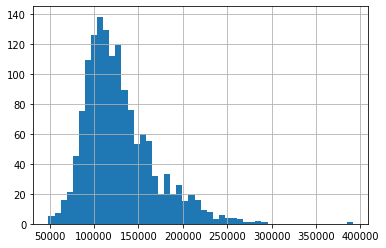

In [45]:
# now let's load the trained model
lin_model = joblib.load('models/linear_regression.joblib') 

# let's obtain the predictions
pred = lin_model.predict(X_test)

# let's plot the predicted sale prices
pd.Series(np.exp(pred)).hist(bins=50);

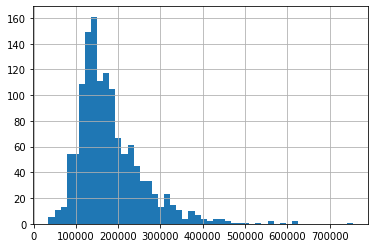

In [59]:
y_train = pd.read_csv('models/ytrain.csv')
y_train.SalePrice.apply(np.exp).hist(bins=50);

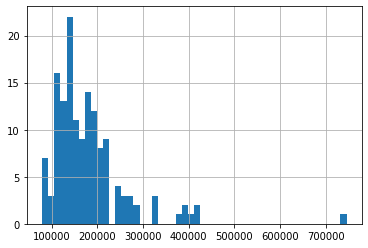

In [60]:
y_valid = pd.read_csv('models/yvalid.csv')
y_valid.SalePrice.apply(np.exp).hist(bins=50);

In [63]:
len(y_train), len(y_valid), len(pred)

(1314, 146, 1459)

## Issues

* Re-wrote a lot of code $\implies$ repetitive
* Hard coded a lot of parameters $\implies$ if these change we need to re-write them again
* Engineered a lot of variables that we actually do not need for the model
* Additional variables present missing data, we do not know what to do with them
* We can minimize these hurdles by using open-source software.

